### Configuration

In [1]:
# Importing NumCosmo
import os
import sys
import gi

gi.require_version('NumCosmo', '1.0')
gi.require_version('NumCosmoMath', '1.0')
from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

os.environ['CLMM_MODELING_BACKEND'] = 'nc'

__name__ = "NcContext"

Ncm.cfg_init()
Ncm.cfg_set_log_handler(lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())


# Importing Numpy and SciPy and time 
import numpy as np
import scipy as sp
from numpy import random
from time import perf_counter


# Importing matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

plt.rcParams['text.latex.preamble'] = r'\usepackage{pxfonts, mathpazo}'
plt.rc('text', usetex=True)


# Importing ks R package and functions
import rpy2
from rpy2 import robjects
from rpy2.robjects.packages import importr

ks       = importr("ks")
vector   = robjects.r["as.vector"]
sphere   = robjects.r["pre.sphere"]
t        = robjects.r["t"]
Hscv     = robjects.r["Hscv"]
kde      = robjects.r["kde"]
plot_kde = robjects.r["plot"]

### Building samples and underlying distributions

In [2]:
# Setting seed
np.random.seed(0)


# Defining PDFs
def gaussian_pdf(x, mu=0, s=1):
    return np.exp(-(x-mu)**2 / (2*s)) / (np.sqrt(2*np.pi)) 


# Creating random samples
ndata        = 1000

samples      = []
samples_long = []

for i in range(ndata):
    x = np.random.normal(0, 1)
    y = np.random.normal(0, 1)
    z = np.random.normal(0, 1)
    samples.append([x, y, z])
    samples_long.append(x)
    samples_long.append(y)
    samples_long.append(z)

samples = np.array(samples)

# Creating sphered samples
samples_vec_r = vector(samples_long, mode="numeric")
samples_r     = robjects.r["matrix"](samples_vec_r, ncol=3, byrow=True)
samples_sph_r = sphere(samples_r)
samples_sph   = np.array(samples_sph_r)

### Calculating bandwidth with Hscv

In [3]:
# Calculating bandwidth using SAMSE and unconstr
t0          = perf_counter()
bw_samse    = Hscv(x=samples_r, nstage=1, pilot="samse")
t1          = perf_counter()

print("Time SAMSE: ", t1-t0)

bw_unconstr = Hscv(x=samples_r, nstage=1, pilot="unconstr")
t2          = perf_counter()

print("Time Unconstr: ", t2-t1)

Time SAMSE:  22.550332350001554
Time Unconstr:  20.109297264993074


### Creating control and test KDEs

In [4]:
# Creating control KDE with RoT
kernel_control = Ncm.StatsDistKernelGauss.new(3)
kde_control    = Ncm.StatsDistKDE.new(kernel_control, Ncm.StatsDistCV.NONE)

for i in range(ndata):
    kde_control.add_obs(Ncm.Vector.new_array(samples[i]))

kde_control.prepare()


# Creating test KDE with Hscv SAMSE bandwidth
kernel_test_samse = Ncm.StatsDistKernelGauss.new(3)
kde_test_samse    = Ncm.StatsDistKDE.new(kernel_test_samse, Ncm.StatsDistCV.NONE)

for i in range(ndata):
    kde_test_samse.add_obs(Ncm.Vector.new_array(samples[i]))

kde_test_samse.set_cov_type(Ncm.StatsDistKDECovType.FIXED)
kde_test_samse.set_cov_fixed(Ncm.Matrix.new_array([bw_samse[i] for i in range(len(bw_samse))], 3))
kde_test_samse.prepare()


# Creating test KDE with Hscv unconstr bandwidth
kernel_test_unconstr = Ncm.StatsDistKernelGauss.new(3)
kde_test_unconstr    = Ncm.StatsDistKDE.new(kernel_test_unconstr, Ncm.StatsDistCV.NONE)

for i in range(ndata):
    kde_test_unconstr.add_obs(Ncm.Vector.new_array(samples[i]))

kde_test_unconstr.set_cov_type(Ncm.StatsDistKDECovType.FIXED)
kde_test_unconstr.set_cov_fixed(Ncm.Matrix.new_array([bw_unconstr[i] for i in range(len(bw_unconstr))], 3))
kde_test_unconstr.prepare()

kde_test_unconstr.set_over_smooth(kde_test_unconstr.get_over_smooth() / kde_test_unconstr.get_href())
print(kde_test_unconstr.get_href())
kde_test_unconstr.prepare()







1.0


### Plotting KDEs against histograms and real distributions

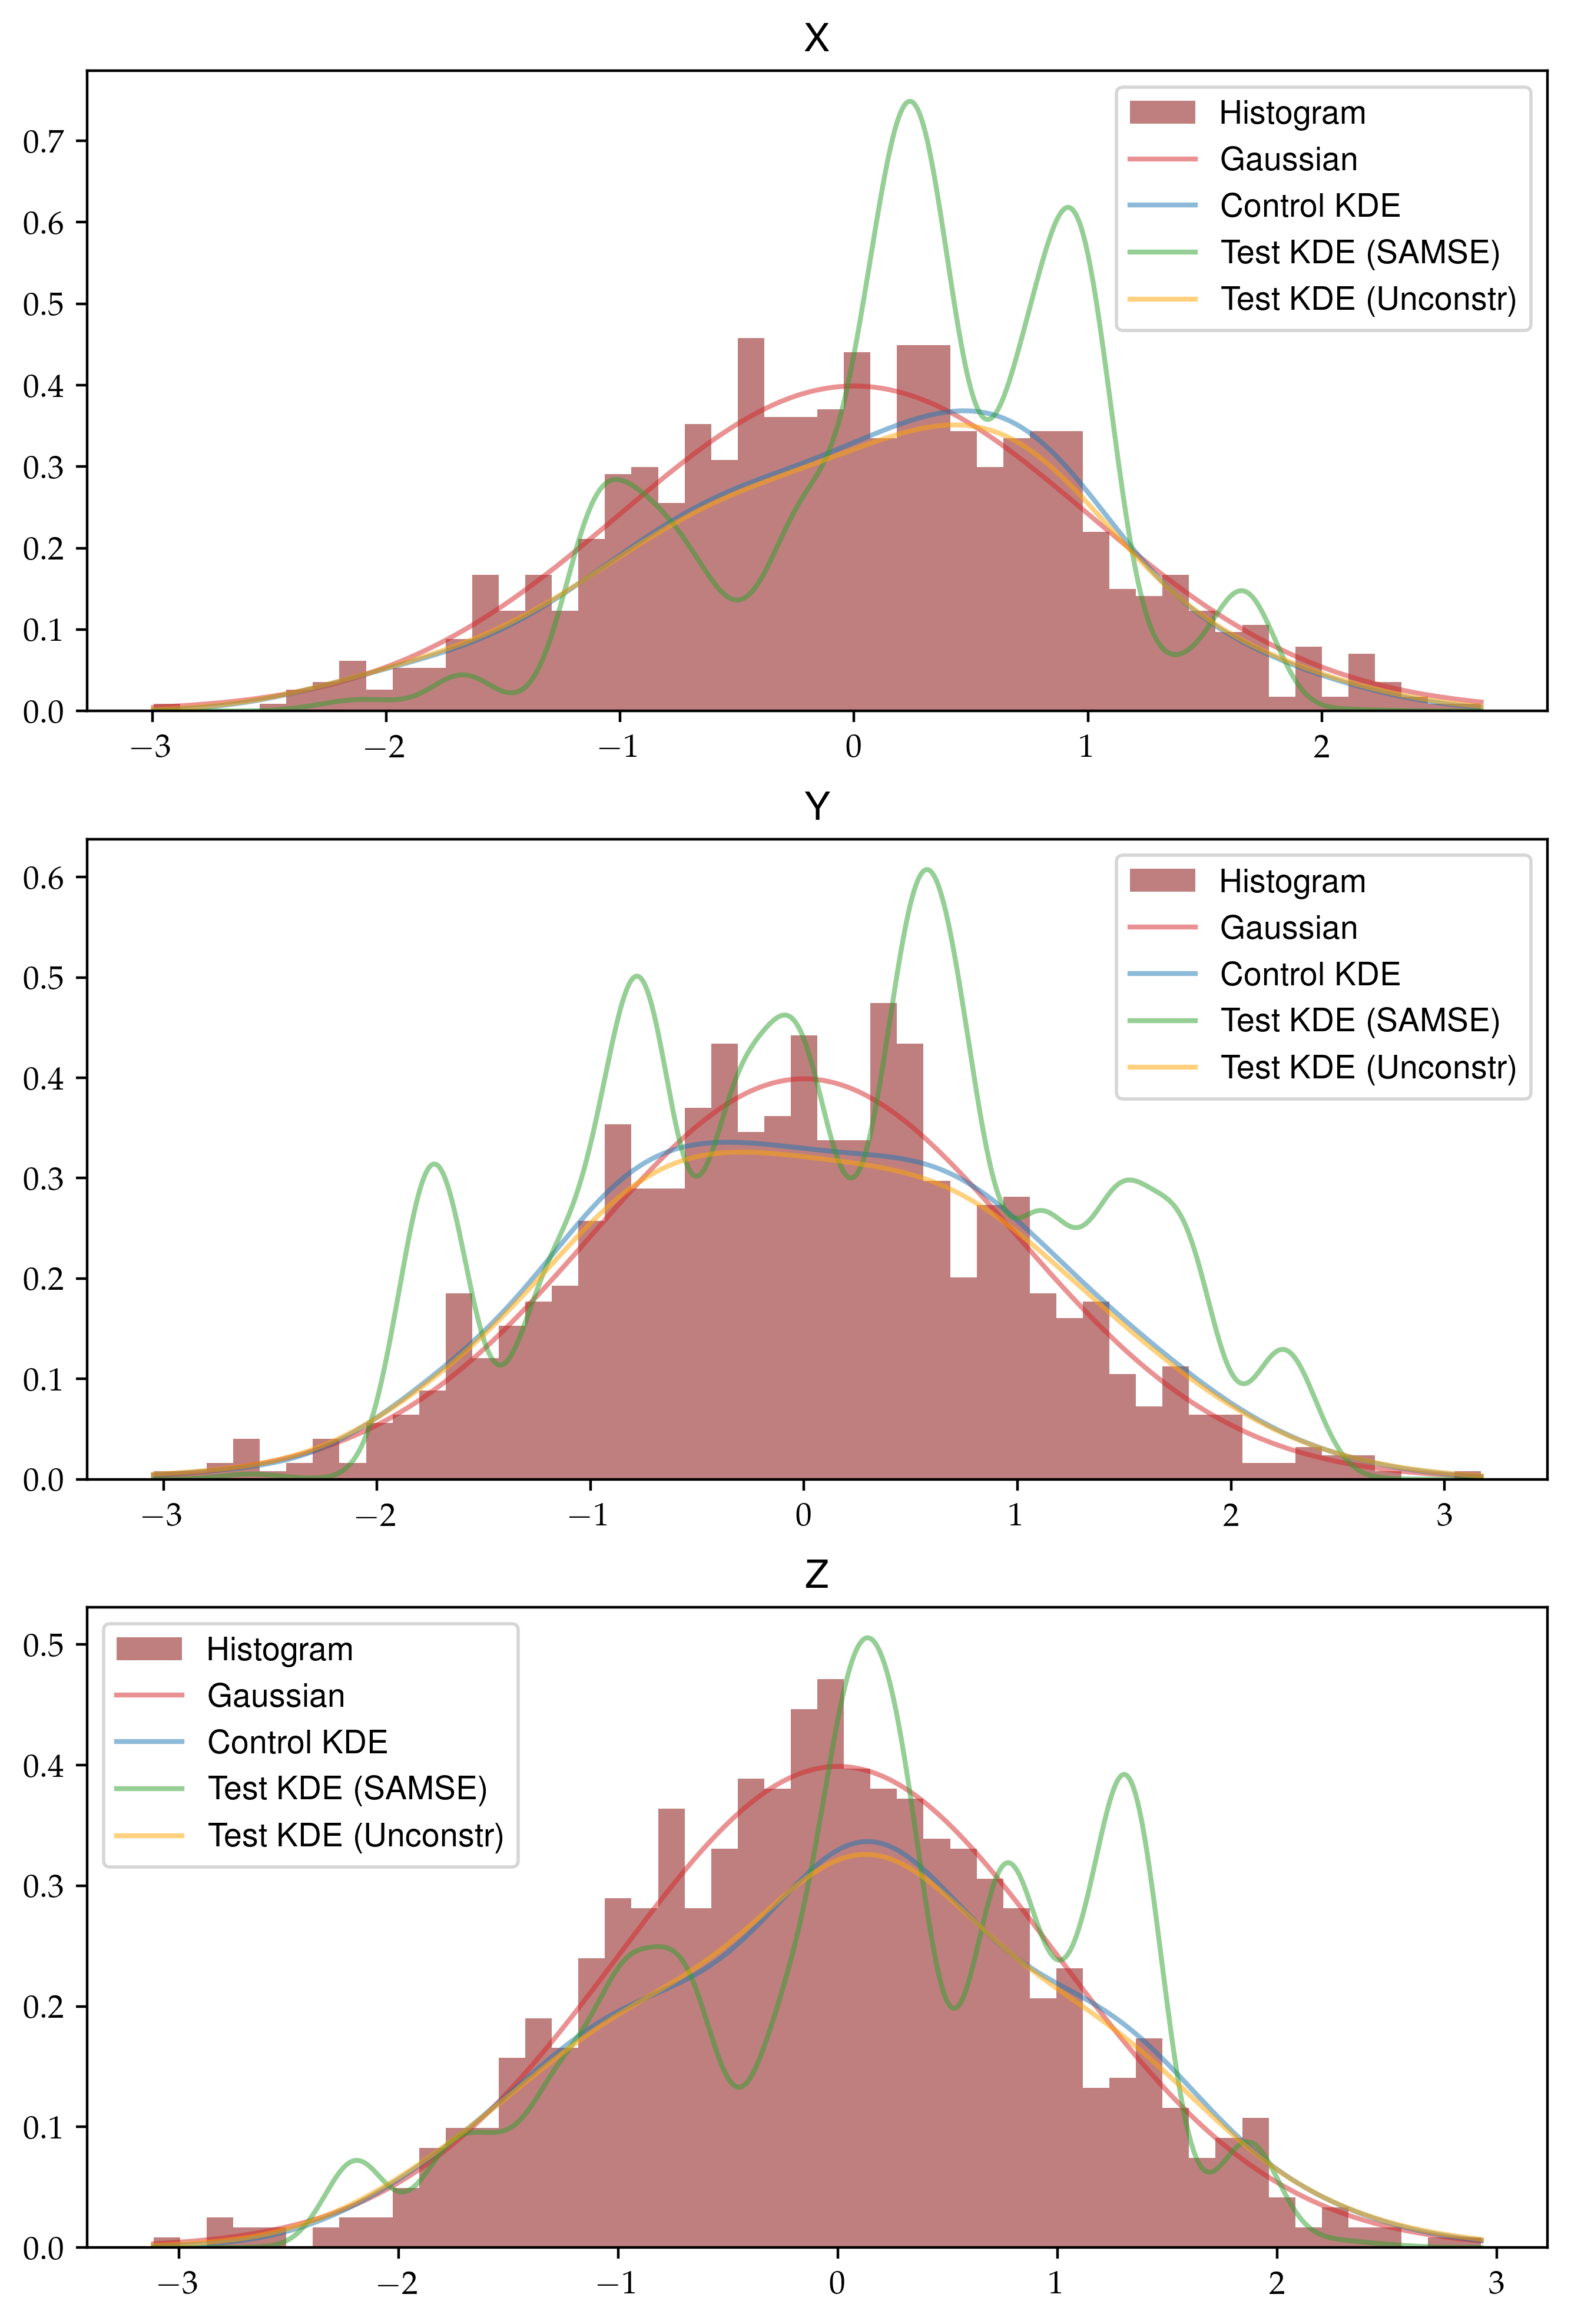

In [5]:
fig, ax = plt.subplots (3, 1, figsize=(8, 12), dpi=400, facecolor="white")

x = np.linspace(min(samples[:,0]), max(samples[:,0]), 1000)
y = np.linspace(min(samples[:,1]), max(samples[:,1]), 1000)
z = np.linspace(min(samples[:,2]), max(samples[:,2]), 1000)


# Plotting histograms
ax[0].hist(samples[:,0], bins=50, density=True, label="Histogram", alpha=0.5, color="maroon")
ax[1].hist(samples[:,1], bins=50, density=True, label="Histogram", alpha=0.5, color="maroon")
ax[2].hist(samples[:,2], bins=50, density=True, label="Histogram", alpha=0.5, color="maroon")


# Plotting distributions
ax[0].plot(x, gaussian_pdf(x), label="Gaussian", color="tab:red", alpha=0.5)
ax[1].plot(y, gaussian_pdf(y), label="Gaussian", color="tab:red", alpha=0.5)
ax[2].plot(z, gaussian_pdf(z), label="Gaussian", color="tab:red", alpha=0.5)


# Plotting KDEs
x_control  = [kde_control.eval(Ncm.Vector.new_array([x[i], 0, 0])) for i in range(len(x))]
x_control  = [x_i/gaussian_pdf(0)**2 for x_i in x_control]
x_samse    = [kde_test_samse.eval(Ncm.Vector.new_array([x[i], 0, 0])) for i in range(len(x))]
x_samse    = [x_i/gaussian_pdf(0)**2 for x_i in x_samse]
x_unconstr = [kde_test_unconstr.eval(Ncm.Vector.new_array([x[i], 0, 0])) for i in range(len(x))]
x_unconstr = [x_i/gaussian_pdf(0)**2 for x_i in x_unconstr]

y_control  = [kde_control.eval(Ncm.Vector.new_array([0, y[i], 0])) for i in range(len(y))]
y_control  = [y_i/gaussian_pdf(0)**2 for y_i in y_control]
y_samse    = [kde_test_samse.eval(Ncm.Vector.new_array([0, y[i], 0])) for i in range(len(y))]
y_samse    = [y_i/gaussian_pdf(0)**2 for y_i in y_samse]
y_unconstr = [kde_test_unconstr.eval(Ncm.Vector.new_array([0, y[i], 0])) for i in range(len(y))]
y_unconstr = [y_i/gaussian_pdf(0)**2 for y_i in y_unconstr]

z_control  = [kde_control.eval(Ncm.Vector.new_array([0, 0, z[i]])) for i in range(len(z))]
z_control  = [z_i/gaussian_pdf(0)**2 for z_i in z_control]
z_samse    = [kde_test_samse.eval(Ncm.Vector.new_array([0, 0, z[i]])) for i in range(len(z))]
z_samse    = [z_i/gaussian_pdf(0)**2 for z_i in z_samse]
z_unconstr = [kde_test_unconstr.eval(Ncm.Vector.new_array([0, 0, z[i]])) for i in range(len(z))]
z_unconstr = [z_i/gaussian_pdf(0)**2 for z_i in z_unconstr]

ax[0].plot(x, x_control, label="Control KDE", color="tab:blue", alpha=0.5)
ax[0].plot(x, x_samse, label="Test KDE (SAMSE)", color="tab:green", alpha=0.5)
ax[0].plot(x, x_unconstr, label="Test KDE (Unconstr)", color="orange", alpha=0.5)

ax[1].plot(y, y_control, label="Control KDE", color="tab:blue", alpha=0.5)
ax[1].plot(y, y_samse, label="Test KDE (SAMSE)", color="tab:green", alpha=0.5)
ax[1].plot(y, y_unconstr, label="Test KDE (Unconstr)", color="orange", alpha=0.5)

ax[2].plot(z, z_control, label="Control KDE", color="tab:blue", alpha=0.5)
ax[2].plot(z, z_samse, label="Test KDE (SAMSE)", color="tab:green", alpha=0.5)
ax[2].plot(z, z_unconstr, label="Test KDE (Unconstr)", color="orange", alpha=0.5)

ax[0].set_title("X")
ax[1].set_title("Y")
ax[2].set_title("Z")
ax[0].legend()
ax[1].legend()
ax[2].legend()